### Setup imports

In [27]:
import torch
import torch.nn as nn

from easydict import EasyDict
from tqdm import tqdm
import time
from utils import set_seed, inference
from utils.data import build_loader

In [28]:
config = EasyDict({'data_dir': './gan_dataset/brain_2d',
                   'seed': 42,
                   'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                   'batch_size': 10,
                   'num_workers': 1,
                   'lr': 1e-5,
                   'epochs': 10,
                   'save_interval': 10})


set_seed(config.seed)
train_loader, val_ds = build_loader(config)

number data points 7500
num train data points: 6000
num val data points: 1500


# Build Model

In [33]:
class UNetGenerator(nn.Module):
    def __init__(self, in_chan=3):
        super().__init__()

        def conv_block(in_chan, out_chan, kernel_size=3, stride=1, padding=1, bias=True):
            return nn.Sequential(*[nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                                   nn.BatchNorm2d(out_chan),
                                   nn.ReLU()])

        self.enc1 = nn.Sequential(*[conv_block(in_chan, 64),
                                    conv_block(64, 64),
                                   nn.MaxPool2d(kernel_size=2)])

        self.enc2 = nn.Sequential(*[conv_block(64, 128),
                                    conv_block(128, 128),
                                   nn.MaxPool2d(kernel_size=2)])
        
        self.enc3 = nn.Sequential(*[conv_block(128, 256),
                                    conv_block(256, 256),
                                   nn.MaxPool2d(kernel_size=2)])
        
        self.enc4 = nn.Sequential(*[conv_block(256, 512),
                                    conv_block(512, 512),
                                   nn.MaxPool2d(kernel_size=2)])

        
        self.dec5 = nn.Sequential(*[conv_block(512, 256),
                                   nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.dec6 = nn.Sequential(*[conv_block(2*256, 256),
                                    conv_block(256, 128),
                                    nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.dec7 = nn.Sequential(*[conv_block(2*128, 128),
                                    conv_block(128, 64),
                                    nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.dec8 = nn.Sequential(*[conv_block(2 * 64, 64),
                                    nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)])
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec5 = self.dec5(enc4)
        cat = torch.cat((dec5, enc3), dim=1)
        dec6 = self.dec6(cat)

        cat = torch.cat((dec6, enc2), dim=1)
        dec7 = self.dec7(cat)

        cat = torch.cat((dec7, enc1), dim=1)
        dec8 = self.dec8(cat)

        out = self.fc(dec8)

        return out

In [34]:
model = UNetGenerator().to(config.device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), config.lr)

## Train Model

In [35]:
def train(model, loader, optimizer, criterion, device):
    losses = []
    model.train()
    for batch in tqdm(loader):
        inputs = batch["input"].to(device) 
        gt = batch["output"].to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, gt)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())     
    return losses

In [36]:
global_tr_losses = []
for epoch in range(config.epochs):
    start_time = time.time()

    model = model.to(config.device)
    tr_losses = train(model, train_loader, optimizer, criterion, config.device)
            
    global_tr_losses.append(sum(tr_losses) / len(tr_losses))

    print(f"Epoch [{epoch + 1}/{config.epochs}], "
          f"TRNLoss: {global_tr_losses[-1]:.4f}, "
          f"Time: {(time.time() - start_time) / 60:.2f}")
            
    if (epoch + 1) % config.save_interval == 0 or epoch == config.epochs - 1:
        torch.save(model.state_dict(), f"./unet_{(epoch+1):04d}.pth")

100%|██████████| 600/600 [03:16<00:00,  3.05it/s]


Epoch [1/10], TRNLoss: 0.0465, Time: 3.28


100%|██████████| 600/600 [03:13<00:00,  3.09it/s]


Epoch [2/10], TRNLoss: 0.0273, Time: 3.23


100%|██████████| 600/600 [03:12<00:00,  3.12it/s]


Epoch [3/10], TRNLoss: 0.0247, Time: 3.21


100%|██████████| 600/600 [03:15<00:00,  3.07it/s]


Epoch [4/10], TRNLoss: 0.0227, Time: 3.26


100%|██████████| 600/600 [03:13<00:00,  3.11it/s]


Epoch [5/10], TRNLoss: 0.0214, Time: 3.22


100%|██████████| 600/600 [03:13<00:00,  3.10it/s]


Epoch [6/10], TRNLoss: 0.0203, Time: 3.23


100%|██████████| 600/600 [03:13<00:00,  3.11it/s]


Epoch [7/10], TRNLoss: 0.0192, Time: 3.22


100%|██████████| 600/600 [03:13<00:00,  3.10it/s]


Epoch [8/10], TRNLoss: 0.0184, Time: 3.22


100%|██████████| 600/600 [03:12<00:00,  3.11it/s]


Epoch [9/10], TRNLoss: 0.0178, Time: 3.21


100%|██████████| 600/600 [03:14<00:00,  3.09it/s]

Epoch [10/10], TRNLoss: 0.0172, Time: 3.23


C:\Users\user\AppData\Local\Temp\ipykernel_37512\2617018908.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_0010.pth'))


0.0031644220289308578


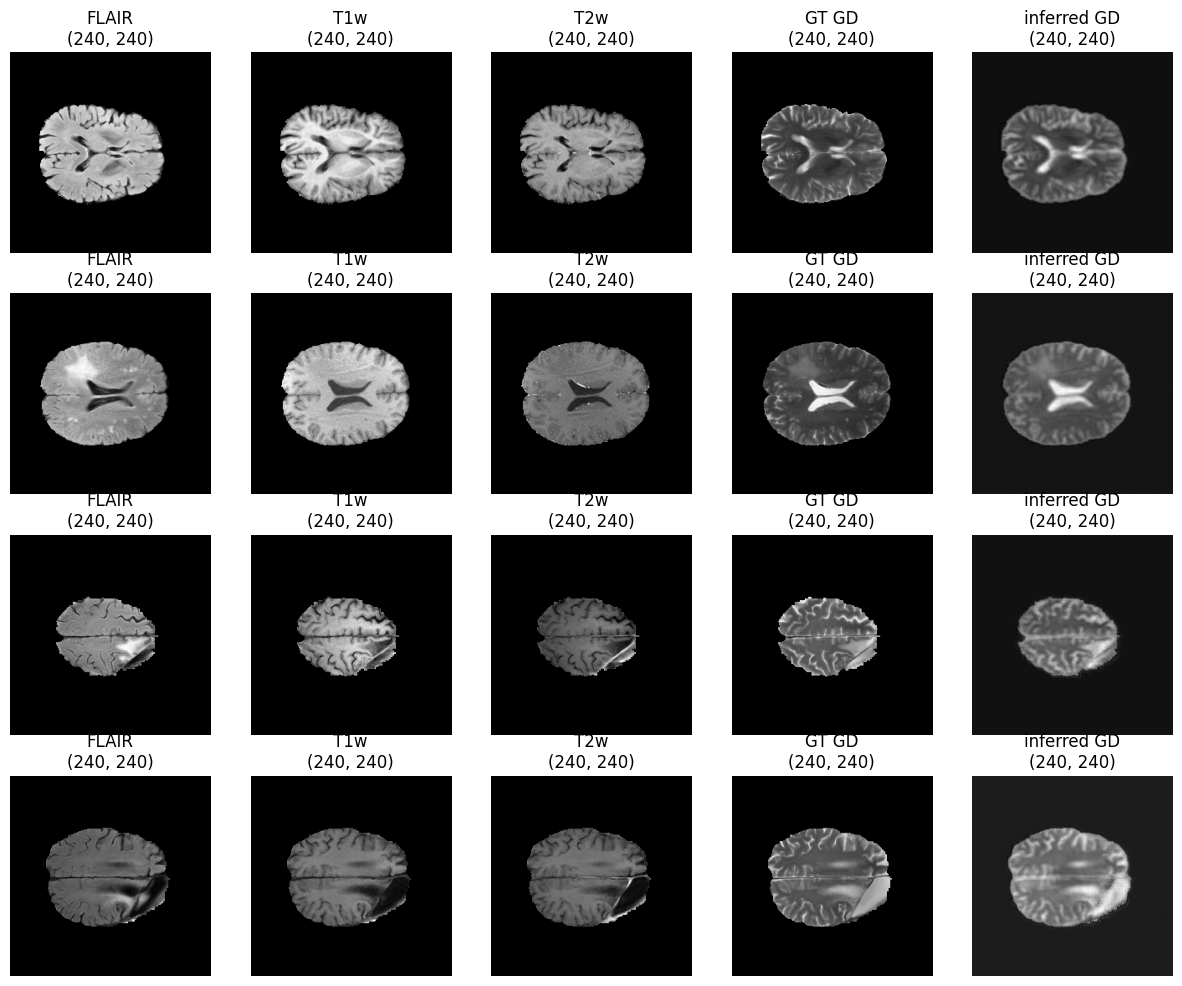

In [37]:
model = UNetGenerator().to(config.device)
model.load_state_dict(torch.load('unet_0010.pth'))
inference(model, val_ds, config, num_data=4)